# Get the MNIST data set.

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Look at shape of mnist data.

In [3]:
# Data set is split into data & targets.
X = mnist["data"].astype(int)
y = mnist["target"].astype(int)

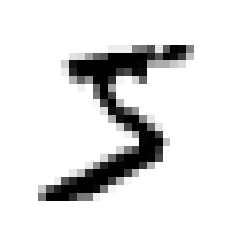

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Each entity is a row of 784 values. These values represent a 28x28 matrix of 
# grey scale image.
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

Split a test-set off. Hint: The MNIST data set is already shuffled. No need to randomly sample.

# Training a binary classifer

Simplify problem for now. Only classify if a img represent a 5 or not.

In [5]:
X_train = X[:60000]
X_test  = X[60000:]
y_train = y[:60000]
y_test  = y[60000:]

In [6]:
y_train_5 = y_train == 5
y_test_5  = y_test  == 5

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(
    X=X_train,
    y=y_train_5
)

SGDClassifier(random_state=42)

Test on our image

In [8]:
sgd_clf.predict([some_digit])

array([ True])

# Performance measure

## Cross-Validation

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(
    estimator=sgd_clf,
    X=X_train,
    y=y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.95035, 0.96035, 0.9604 ])

95.035% accuracy? Seems a bit high. Lets try to classifiy "not a 5".

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accurate. This is due to the fact that ca. 10% of the samples are 5s. If we always guess 'not a 5' we are 90% right. Accuracy is  ususally not the preferred performance measure.

## Confustion Matrix

Idea: Count the number of times an instane of class A got classified as class B. 

In [11]:
# Get the prediction, not the scores.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(
    estimator=sgd_clf,
    X=X_train,
    y=y_train_5,
    cv=3,
)

In [12]:
# Calculate the confusion matrix.
# How many times got a 5 predicted as not a 5 and vice-versa.
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

This matrix represents: <br>
[True Negativ, False Positive] <br>
[False Negative, Ture Positive]

The confusion matrix gives you a lot of information. But sometimes you might want a number.

- Precision = TP / (TP + FP): Accuracy of positive predictions. What proportion of positive identifications was actually correct?
- Recall or Sensitivity or True Posistive Rate = TP / (TP + FN). What proportion of actual positives was identified correctly?
- F_1 = TP / (TP + ((FN + FP) / 2))

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precison
precision_score(y_train_5, y_train_pred)

# Recall
recall_score(y_train_5, y_train_pred)

# F1
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 favours classifiers with similar precision and recall. Increasing precision reduces recall and vice versa. **Precision/Recall Trade-off**

#### Tradoff precision vs recall

In [14]:
# Get score of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [15]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

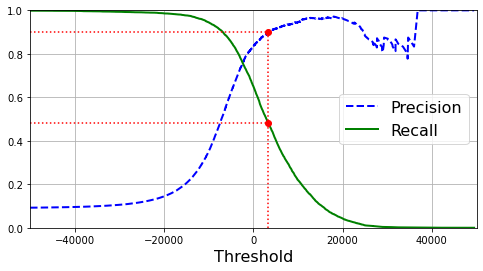

In [16]:
# Visualiz
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Another way to find a good trade off between those two is to plot them against each other.

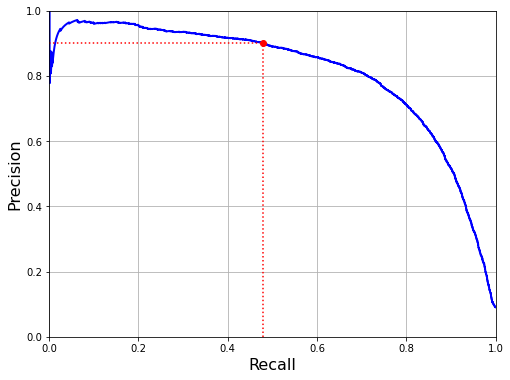

In [17]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

Lets say we want to find a threshold that gives at least 90% precision:

In [18]:
# Get the threshold that provide >= 0.9 precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439566


In [19]:
# Test it
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [20]:
# What is the recall score here:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706